In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as sps

In [2]:
def read_file(name):
    data = pd.read_csv(name)
    data = data[data['Volume'] > 0]
    data['date'] = data['Local time'].str[:10]
    data['price'] = (data['High'] + data['Low']) / 2
    data = data[['date', 'price']].groupby('date').mean()
    data.index = pd.to_datetime(data.index, format='%d.%m.%Y')
    data.sort_index(inplace=True)
    return data

def get_data(bid_name, ask_name, alpha=0.99):
    bid = read_file(bid_name)
    bid.columns = ['bid']
    
    ask = read_file(ask_name)
    ask.columns = ['ask']
    
    data = pd.concat([bid, ask], axis=1)
    data['spread'] = (data['ask'] - data['bid'])
    data['mid'] = (data['ask'] + data['bid']) / 2
    data['relative_spread'] = data['spread'] / data['mid']
    data['log_relative_spread'] = np.log(data['relative_spread'])
    
    data['return'] = pd.Series(np.log(data['mid'][:-1]).values - np.log(data['mid'][1:]).values,
                               index=data.index[1:])
    
    return data

def get_offline_stats(data, log_norm=False):
    sigma_return = np.std(data['return'])
    mean_return = np.mean(data['return'])
    
    spread_type = 'log_relative_spread' if log_norm else 'relative_spread'

    sigma_relative_spread = np.std(data[spread_type])
    mean_relative_spread = np.mean(data[spread_type])
    
    last_mid = data['mid'][-1]
    min_price = last_mid * (np.exp(mean_return - sigma_return * sps.norm.ppf(0.99)))
    
    var = last_mid - min_price
    if log_norm:
        col = 0.5 * (last_mid * np.exp(mean_relative_spread + sigma_relative_spread * sps.norm.ppf(0.99)))
    else:
        col = 0.5 * (last_mid * (mean_relative_spread + sigma_relative_spread * sps.norm.ppf(0.99)))
    adj_var = var + col
    liquidity_part = col / adj_var
        
    return {
        'sigma_return': sigma_return,
        'mean_return': mean_return,
        'sigma_relative_spread': sigma_relative_spread,
        'mean_relative_spread': mean_relative_spread,
        'last_mid': last_mid,
        'var': var,
        'col': col,
        'adj_var': adj_var,
        'liquidity_part': liquidity_part
    }

def get_shifted_stats(data, size=30, shift=15, log_norm=False):
    stats = pd.DataFrame()
    for i in range(0, data.shape[0] - size, shift):
        stats = stats.append(get_offline_stats(data.iloc[i:i+size], 
                                               log_norm=log_norm), 
                             ignore_index=True)
    return stats

def get_online_stats(data, start_size=30, lambd=0.97, log_norm=False):
    sigma_return = np.std(data.iloc[:start_size]['return'])
    mean_return = np.mean(data.iloc[:start_size]['return'])
    
    spread_type = 'log_relative_spread' if log_norm else 'relative_spread'
    
    sigma_relative_spread = np.std(data.iloc[:start_size][spread_type])
    mean_relative_spread = np.mean(data.iloc[:start_size][spread_type])
    
    last_mid = data['mid'][start_size - 1]
    
    stats = pd.DataFrame()
    
    for date, row in data[start_size:].iterrows():
        min_price = last_mid * (np.exp(mean_return - sigma_return * sps.norm.ppf(0.99)))
        var = last_mid - min_price
        if log_norm:
            col = 0.5 * (last_mid * np.exp(mean_relative_spread + sigma_relative_spread * sps.norm.ppf(0.99)))
        else:
            col = 0.5 * (last_mid * (mean_relative_spread + sigma_relative_spread * sps.norm.ppf(0.99)))
        adj_var = var + col
        liquidity_part = col / adj_var
        
        stats = stats.append({
            'sigma_return': sigma_return,
            'mean_return': mean_return,
            'sigma_relative_spread': sigma_relative_spread,
            'mean_relative_spread': mean_relative_spread,
            'last_mid': last_mid,
            'var': var,
            'col': col,
            'adj_var': adj_var,
            'liquidity_part': liquidity_part
        }, ignore_index=True)
        
        mean_return = lambd * mean_return + (1 - lambd) * row['return']
        sigma_return = np.sqrt(lambd * sigma_return ** 2 + (1 - lambd) * (row['return'] - mean_return) ** 2)
        
        mean_relative_spread = lambd * mean_relative_spread + (1 - lambd) * row[spread_type]
        sigma_relative_spread = np.sqrt(lambd * sigma_relative_spread ** 2 + (1 - lambd) * (row[spread_type] - mean_relative_spread) ** 2)
        
        last_mid = row['mid']
        
    stats.index = data.index[start_size:]
    return stats

In [3]:
def draw_stats_curves(stats, alpha=0.99, save_name=None):


    plt.figure(figsize=(15, 3))
    plt.subplot(1, 5, 1)
    if stats['mean_relative_spread'].mean() < 0:
        plt.title('Log relative spread')
    else:
        plt.title('Relative spread')
    plt.plot(stats['mean_relative_spread'])
    q = sps.norm.ppf(alpha)
    plt.fill_between(stats.index, 
                     stats['mean_relative_spread'] - q * stats['sigma_relative_spread'],
                     stats['mean_relative_spread'] + q * stats['sigma_relative_spread'], alpha=0.3)
    plt.xticks([])
    plt.xlabel('time')
    plt.subplot(1, 5, 2)
    plt.title('Cost of Liquidity')
    plt.plot(stats['col'])
    plt.xlabel('time')
    plt.xticks([])
    plt.subplot(1, 5, 3)
    plt.title('Standard VaR')
    plt.plot(stats['var'])
    plt.xlabel('time')
    plt.xticks([])
    plt.subplot(1, 5, 4)
    plt.title('Adjusted VaR')
    plt.plot(stats['adj_var'])
    plt.xlabel('time')
    plt.xticks([])
    plt.subplot(1, 5, 5)
    plt.title('Liquidity part')
    plt.plot(stats['liquidity_part'])
    plt.xlabel('time')
    plt.xticks([])
    plt.tight_layout()
    if save_name is not None:
        plt.save_fig(save_name)
    plt.show()

In [4]:
def merge_actives(actives, weights):
    bid = None
    ask = None
    for name, w in zip(actives, weights):
        data = get_data(f'{name}_Candlestick_1_m_BID_01.05.2019-01.05.2021.csv', 
                        f'{name}_Candlestick_1_m_ASK_01.05.2019-01.05.2021.csv')

        if bid is None:
            bid = w * data['bid']
            ask = w * data['ask']
        else:
            bid += w * data['bid']
            ask += w * data['ask']

    data = pd.DataFrame({'ask': ask, 'bid': bid})

    data['spread'] = (data['ask'] - data['bid'])
    data['mid'] = (data['ask'] + data['bid']) / 2
    data['relative_spread'] = data['spread'] / data['mid']
    data['log_relative_spread'] = np.log(data['relative_spread'])
    
    data['return'] = pd.Series(np.log(data['mid'][:-1]).values - np.log(data['mid'][1:]).values,
                               index=data.index[1:])
    
    return data

In [5]:
def draw_active(name, online=True, log_norm=False, save_name=None):
    print(f'{name}, {"online" if online else "offline_shifted"}, {"log_norm" if log_norm else "norm"}')
    data = get_data(f'{name}_Candlestick_1_m_BID_01.05.2019-01.05.2021.csv', 
                    f'{name}_Candlestick_1_m_ASK_01.05.2019-01.05.2021.csv')

    stats = None
    if online:
        stats = get_online_stats(data, log_norm=log_norm)
        standard_mistakes = (stats['last_mid'] - stats['var'] > data.loc[stats.index]['bid']).sum()
        adjusted_mistakes = (stats['last_mid'] - stats['adj_var'] > data.loc[stats.index]['bid']).sum()
        size = stats.shape[0]
        print('VaR errors:     {}, {:.2f}%'.format(standard_mistakes, 100 * standard_mistakes / size ))
        print('Adj VaR errors: {}, {:.2f}%'.format(adjusted_mistakes, 100 * adjusted_mistakes / size ))
        
    else:
        stats = get_shifted_stats(data, log_norm=log_norm)
    
    draw_stats_curves(stats, save_name=save_name)

In [6]:
def draw_merged_active(data, online=True, log_norm=False, save_name=None):
    stats = None
    if online:
        stats = get_online_stats(data, log_norm=log_norm)
        standard_mistakes = (stats['last_mid'] - stats['var'] > data.loc[stats.index]['bid']).sum()
        adjusted_mistakes = (stats['last_mid'] - stats['adj_var'] > data.loc[stats.index]['bid']).sum()
        size = stats.shape[0]
        print('VaR errors:     {}, {:.2f}%'.format(standard_mistakes, 100 * standard_mistakes / size ))
        print('Adj VaR errors: {}, {:.2f}%'.format(adjusted_mistakes, 100 * adjusted_mistakes / size ))
        
    else:
        stats = get_shifted_stats(data, log_norm=log_norm)
    
    draw_stats_curves(stats, save_name=save_name)

Посмотрим на различные способы оценки распределения для нахождения ликвидности

AVB.USUSD, online, norm
VaR errors:     13, 2.74%
Adj VaR errors: 10, 2.11%


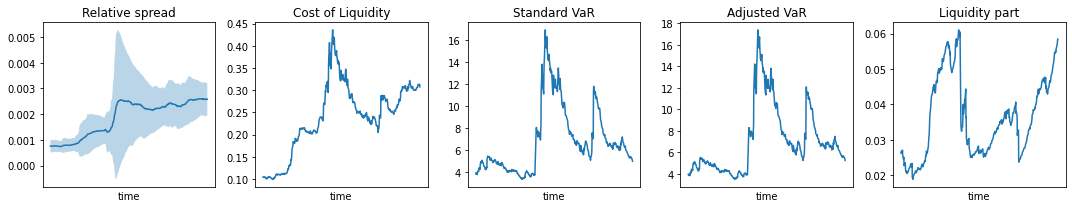

AVB.USUSD, online, log_norm
VaR errors:     13, 2.74%
Adj VaR errors: 10, 2.11%


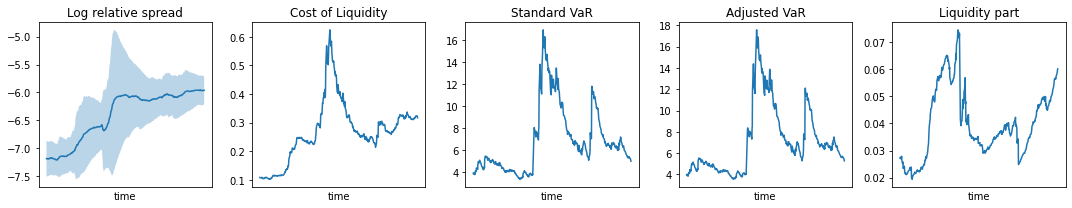

AVB.USUSD, offline_shifted, norm


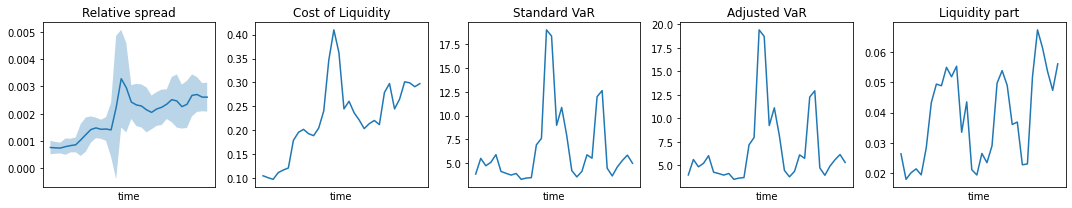

AVB.USUSD, offline_shifted, log_norm


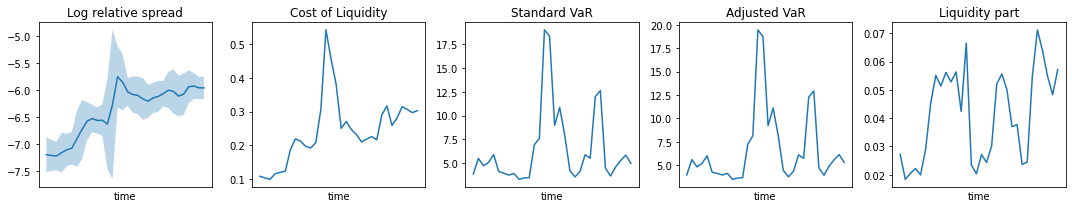

In [7]:
draw_active('AVB.USUSD', online=True, log_norm=False)
draw_active('AVB.USUSD', online=True, log_norm=True)
draw_active('AVB.USUSD', online=False, log_norm=False)
draw_active('AVB.USUSD', online=False, log_norm=True)

Видим, что результат при разных способах оценивания примерно совпадает, исползуем только 1 метод для дальнейших активов

AVB.USUSD, online, norm
VaR errors:     13, 2.74%
Adj VaR errors: 10, 2.11%


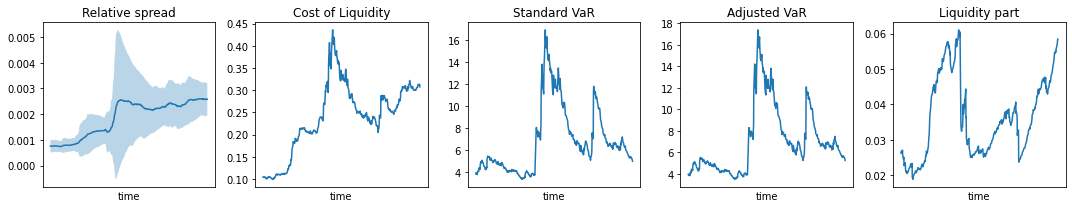

XAUUSD, online, norm
VaR errors:     14, 2.68%
Adj VaR errors: 14, 2.68%


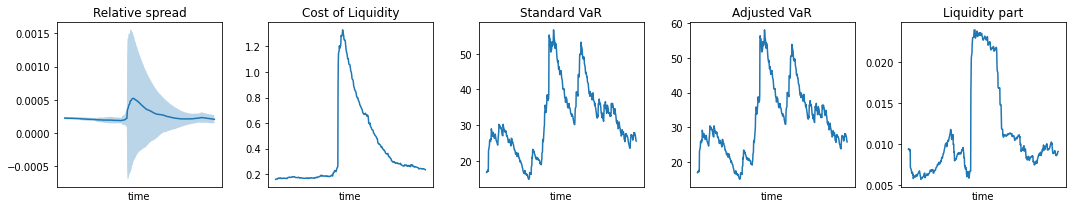

COP.USUSD, online, norm
VaR errors:     13, 2.74%
Adj VaR errors: 13, 2.74%


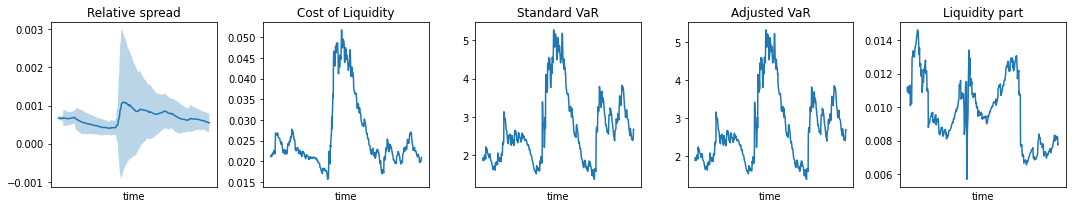

In [8]:
actives = ['AVB.USUSD', 'XAUUSD', 'COP.USUSD']

for active in actives:
    draw_active(active)

Составим из активов портфель и посчитаем ликвидность если считать портфель оодним активом и применить к нему теорию. Переберем различные соотношения весов позиций в портфелеь

VaR errors:     14, 2.95%
Adj VaR errors: 14, 2.95%


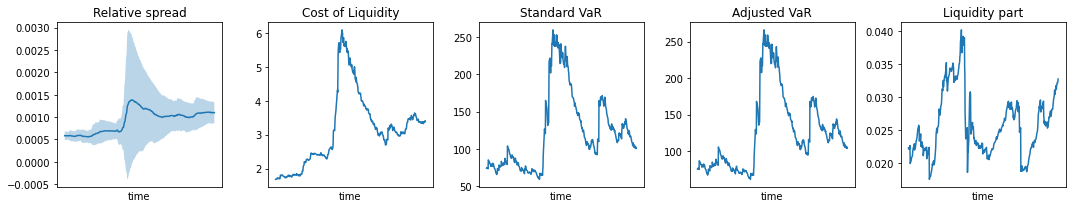

In [9]:
draw_merged_active(merge_actives(actives, [9, 1, 30]))

VaR errors:     13, 2.74%
Adj VaR errors: 10, 2.11%


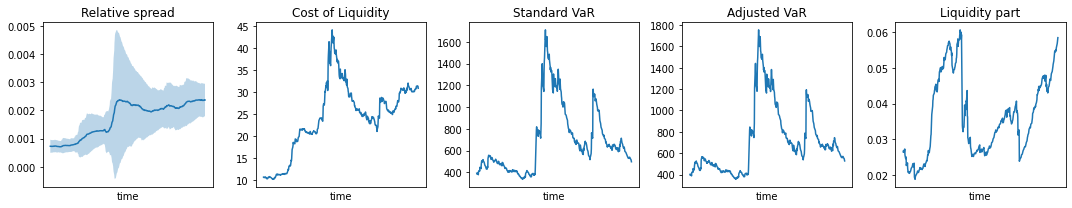

In [10]:
draw_merged_active(merge_actives(actives, [100, 1, 1]))

VaR errors:     11, 2.32%
Adj VaR errors: 11, 2.32%


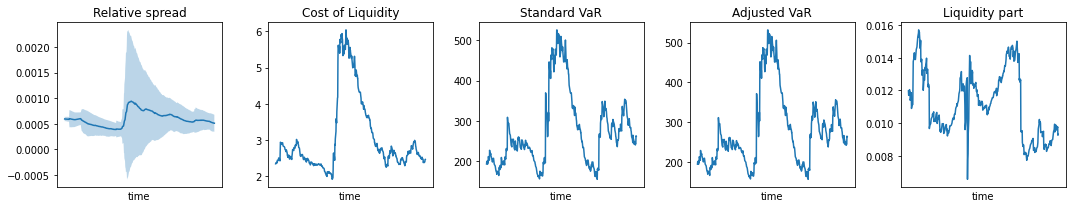

In [11]:
draw_merged_active(merge_actives(actives, [1, 1, 100]))